In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import json
import numpy as np
import re
import string
import nltk
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
import json
# path to the dataset on Kaggle
train_path = '/kaggle/input/train-data/train_data1.json'
with open(train_path, 'r') as file:
    data1 = json.load(file)

test_path = '/kaggle/input/test-data2/test_data1_final.json'
with open(test_path, 'r') as file:
    data2 = json.load(file)


In [ ]:
for lang_pair in data1.keys():
  print(f"Language Pair: {lang_pair}")

Language Pair: English-Bengali
Language Pair: English-Hindi


In [ ]:
for lang_pair in data2.keys():
  print(f"Language Pair: {lang_pair}")

Language Pair: English-Bengali
Language Pair: English-Hindi


In [ ]:
train_inp = []
train_out = []
test_inp = []
test_out = []
train_id = []
val_id = []

In [ ]:
# Train Data collections
for lang_pair, lang_data in data1.items():
    if(lang_pair == "English-Hindi"):
      print(f"Language Pair: {lang_pair}")
      for d_type, cont in lang_data.items():
          print(f"Data Type: {d_type}")
          for id, data in cont.items():
              source = data["source"]
              target = data["target"]
              train_inp.append(source)
              train_out.append(target)
              train_id.append(id)
# Test Data collections
for lang_pair, lang_data in data2.items():
    if(lang_pair == "English-Hindi"):
      print(f"Language Pair: {lang_pair}")
      for d_type, cont in lang_data.items():
          print(f"Data Type: {d_type}")
          for id, data in cont.items():
              source = data["source"]
              test_inp.append(source)

Language Pair: English-Hindi
Data Type: Train
Language Pair: English-Hindi
Data Type: Test


In [ ]:
print(len(train_inp))
print(len(train_out))
print(len(test_inp))
print(len(test_out))

80797
80797
23085
0


In [ ]:
from collections import Counter

In [ ]:
len_sen_source = []
for sen in train_inp:
  len_sen_source.append(len(sen))
len_sen_cnt = Counter(len_sen_source)

In [ ]:
len_sen_cnt.most_common(10)

[(70, 706),
 (72, 697),
 (65, 688),
 (76, 678),
 (66, 678),
 (69, 673),
 (77, 669),
 (60, 669),
 (71, 668),
 (78, 667)]

In [ ]:
x={'English':train_inp,'Hindi':train_out}
df=pd.DataFrame(x)
df.head()

,English,Hindi
0,cancel everything on my calendar,मेरे कैलेंडर पर सब कुछ रद्द करें
1,Adrenal hormone levels are at their peak durin...,अधिवृक्क के हार्मोन का स्तर प्रातःकाल में अपने...
2,"Golden threads are obtained from Surat, the qu...","स्वर्ण धागे सूरत से प्राप्त होते हैं, जिनकी गु..."
3,Look for agglutination within 30 seconds.,30 सेकेण्ड के भीतर एग्लूटिनेशन देखें।
4,The non-pompousness and informality of their l...,उनके जीवन की आडंबरहीनता एवं अनौपचारिकता उनके स...


In [ ]:
# fxn- it preprocess and remove punctuation and digit from sentence
def fxn(sen):
    res = ""
    for ch in sen:
        if ch not in string.punctuation and not ch.isdigit():
            res += ch
    return res

In [ ]:
def preprocess(data):
    tok_sen = []
    for sen in data:
        sen = sen.lower()
        sen = fxn(sen)
        tok = nltk.word_tokenize(sen)
        tok_sen.append(tok)
    return tok_sen


In [ ]:
en_train = preprocess(train_inp)
en_test=preprocess(test_inp)
de_train = preprocess(train_out)
de_test=preprocess(test_out)

In [ ]:
en_train[0]

['cancel', 'everything', 'on', 'my', 'calendar']

In [ ]:
from tqdm import tqdm

In [ ]:
en_idx2_word = ["<PAD>", "<SOS>", "<EOS>"]
de_idx2_word = ["<PAD>", "<SOS>", "<EOS>"]
# for en_train
for sent in en_train:
    for token in sent:
        if token not in en_idx2_word:
            en_idx2_word.append(token)

# for en_test
for sent in en_test:
    for token in sent:
        if token not in en_idx2_word:
            en_idx2_word.append(token)

for sent in de_train:
    for token in sent:
        if token not in de_idx2_word:
            de_idx2_word.append(token)

# # For de_test
# for sent in de_test:
#     for token in sent:
#         if token not in de_idx2_word:
#             de_idx2_word.append(token)


In [ ]:
len(en_idx2_word)

64778

In [ ]:
de_idx2_word[-8:-2]

['ऑंकड़ों', 'फिरोजाबाद', 'समशीतोष्\u200dण', 'शोधक', 'सीएलएबीएसआई', 'टिटवुड']

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
en_word2_idx = {}
de_word2_idx = {}
for i in range(len(en_idx2_word)):
  en_word2_idx[en_idx2_word[i]] = i

for i in range(len(de_idx2_word)):
  de_word2_idx[de_idx2_word[i]] = i



In [ ]:
max_len_en = 0
en_lengths = 0
for sen in en_train:
  max_len_en = max(max_len_en,len(sen))
  en_lengths+=len(sen)
en_lengths  = en_lengths/len(en_train)
max_len_en

255

In [ ]:
tot_en_len = 0
en_maxi  = 0
for sen in en_train:
    tot_en_len += len(sen)
    en_maxi = max(en_maxi,len(sen))
en_avg = tot_en_len / len(en_train)

tot_de_len = 0
de_maxi = 0
for sen in de_train:
    tot_de_len += len(sen)
    de_maxi = max(de_maxi,len(sen))
de_avg = tot_de_len / len(de_train)

In [ ]:
de_avg

18.32887359679196

In [ ]:
en_avg

16.307808458234835

In [ ]:
print(en_maxi,de_maxi)

255 213


In [ ]:
seq_len = 75

In [ ]:
def enc_pad(vocab, sen, maxi):
    sos = [vocab["<SOS>"]]
    eos = [vocab["<EOS>"]]
    pad = [vocab["<PAD>"]]

    if len(sen) < maxi - 2:
        n_pads = maxi - 2 - len(sen)
        enc = []
        for w in sen:
            enc.append(vocab[w])
        return sos + enc + eos + pad * n_pads
    else:
        enc = []
        for w in sen:
            enc.append(vocab[w])
        enc = enc[:maxi - 2]
        return sos + enc + eos

In [ ]:
en_train_enc = []
for sent in en_train:
    enc = enc_pad(en_word2_idx, sent, seq_len)
    en_train_enc.append(enc)

en_test_enc = []
for sent in en_test:
    enc = enc_pad(en_word2_idx, sent, seq_len)
    en_test_enc.append(enc)

de_train_enc = []
for sent in de_train:
    enc = enc_pad(de_word2_idx, sent, seq_len)
    de_train_enc.append(enc)

# de_test_enc = []
# for sent in de_test:
#     enc = enc_pad(de_word2_idx, sent, seq_len)
#     de_test_enc.append(enc)


In [ ]:
print(en_train_enc[8])

[1, 104, 105, 106, 107, 63, 108, 109, 16, 110, 31, 111, 63, 112, 34, 113, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
batch_size = 32

train_x = np.array(en_train_enc)
train_y = np.array(de_train_enc)
test_x = np.array(en_test_enc)
# test_y = np.array(de_test_enc)

train_ds = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
test_ds = TensorDataset(torch.from_numpy(test_x))


train_dl = DataLoader(train_ds, shuffle=True, batch_size=batch_size, drop_last=True)
#test_dl = DataLoader(test_ds, shuffle=True, batch_size=batch_size, drop_last=True)

In [ ]:
import torch
import torch.nn as nn

class EncoderBiLSTM(nn.Module):
    def __init__(self, inps, hs, emb_len=128, num_lay=3):
        super(EncoderBiLSTM, self).__init__()
        self.num_lay = num_lay
        self.hs = hs
        self.embed = nn.Embedding(inps, emb_len)
        self.lstm = nn.LSTM(
            emb_len, hs, num_layers=num_lay,
            batch_first=True, bidirectional=True
        )

    def forward(self, inp, hid, cell):
        embed = self.embed(inp)
        output, (hidden, cell) = self.lstm(embed, (hid, cell))
        return output, hidden, cell

    def ini_hid(self, batch_size, device):
        hid = torch.zeros(self.num_lay * 2, batch_size, self.hs, device=device)
        cell = torch.zeros(self.num_lay * 2, batch_size, self.hs, device=device)
        return hid, cell


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DecoderBiLSTM(nn.Module):
    def __init__(self, hs, out_s, emb_len=128, num_lay=3):
        super(DecoderBiLSTM, self).__init__()
        self.hs = hs
        self.num_layers = num_lay
        self.emb = nn.Embedding(out_s, emb_len)
        enc_hs = hs * 2
        # Bahdanu Attention
        self.w_h = nn.Linear(enc_hs, hs)
        self.w_s = nn.Linear(hs, hs)
        self.v = nn.Linear(hs, 1, bias=False)

        self.lstm = nn.LSTM(emb_len + enc_hs, hs, num_layers=num_lay, batch_first=True)
        self.out = nn.Linear(hs + enc_hs, out_s)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, inp, hid, cell, enc_out):
        emb = self.emb(inp)  # (batch, 1, emb_len)
        dec_hid = hid[-1].unsqueeze(1)  # (batch, 1, hs)

        x = torch.tanh(self.w_h(enc_out) + self.w_s(dec_hid))
        scores = self.v(x).squeeze(2)
        attn_weights = F.softmax(scores, dim=1)

        context = torch.bmm(attn_weights.unsqueeze(1), enc_out)

        lstm_input = torch.cat((emb, context), dim=2)
        out, (hid, cell) = self.lstm(lstm_input, (hid, cell))

        out = out.squeeze(1)
        context = context.squeeze(1)

        out = self.out(torch.cat((out, context), dim=1))
        out = self.softmax(out)

        return out, hid, cell


In [ ]:
# define hidden_size
hidden_size = 128


In [ ]:
encoder = EncoderBiLSTM(len(en_idx2_word), hidden_size).to(device)
decoder = DecoderBiLSTM(hidden_size, len(de_idx2_word)).to(device)

In [ ]:
encoder

EncoderBiLSTM(
  (embed): Embedding(64778, 128)
  (lstm): LSTM(128, 128, num_layers=3, batch_first=True, bidirectional=True)
)

In [ ]:
decoder

DecoderBiLSTM(
  (emb): Embedding(75178, 128)
  (w_h): Linear(in_features=256, out_features=128, bias=True)
  (w_s): Linear(in_features=128, out_features=128, bias=True)
  (v): Linear(in_features=128, out_features=1, bias=False)
  (lstm): LSTM(384, 128, num_layers=3, batch_first=True)
  (out): Linear(in_features=384, out_features=75178, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [ ]:
criterion = nn.NLLLoss()
enc_optimizer = torch.optim.Adam(encoder.parameters(), lr = 1e-3)
dec_optimizer = torch.optim.Adam(decoder.parameters(), lr = 1e-3)

In [ ]:
losses = []

In [ ]:
input_length = target_length = seq_len
SOS = en_word2_idx["<SOS>"]
EOS = en_word2_idx["<EOS>"]

In [ ]:
epochs = 5
import random

In [ ]:
import torch
import random
# setting teacher force ratio to 1
tfr = 1

for epoch in range(epochs):
    for idx, batch in enumerate(train_dl):
        batch_size = batch[0].size(0)
        enc_hid, enc_cell = encoder.ini_hid(batch_size, device)

        inp_ten = batch[0].to(device)
        tar_ten = batch[1].to(device)
        tar_len = tar_ten.size(1)

        enc_optimizer.zero_grad()
        dec_optimizer.zero_grad()

        enc_out, enc_hid, enc_cell = encoder(
            inp_ten, enc_hid, enc_cell
        )

        def merge_bidir(hidden):
            hidden = hidden.view(encoder.num_lay, 2, batch_size, encoder.hs)
            return torch.tanh(hidden[:, 0, :, :] + hidden[:, 1, :, :])

        dec_hid = merge_bidir(enc_hid)
        dec_cell = merge_bidir(enc_cell)

        dec_result = torch.zeros(batch_size, tar_len, len(de_idx2_word), device=device)
        dec_inp = tar_ten[:, 0].unsqueeze(1)

        for t in range(1, tar_len):
            decoder_output, dec_hid, dec_cell = decoder(
                dec_inp, dec_hid, dec_cell, enc_out
            )

            dec_result[:, t, :] = decoder_output

            # teacher forcing
            use = random.random() < tfr
            if use:
                dec_inp = tar_ten[:, t].unsqueeze(1)
            else:
                top1 = decoder_output.argmax(1)
                dec_inp = top1.unsqueeze(1)

        scores = dec_result[:, 1:, :].reshape(-1, dec_result.shape[2])
        targets = tar_ten[:, 1:].reshape(-1)
        loss = criterion(scores, targets)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=1)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=1)
        enc_optimizer.step()
        dec_optimizer.step()

        losses.append(loss.item())
        if idx % 100 == 0:
            avg_loss = sum(losses) / len(losses)
            print(f"Epoch {epoch+1}, Batch {idx}, Avg Loss: {avg_loss:.4f}")


Epoch 1, Batch 0, Avg Loss: 1.1748
Epoch 1, Batch 100, Avg Loss: 1.1708
Epoch 1, Batch 200, Avg Loss: 1.1668
Epoch 1, Batch 300, Avg Loss: 1.1631
Epoch 1, Batch 400, Avg Loss: 1.1592
Epoch 1, Batch 500, Avg Loss: 1.1555
Epoch 1, Batch 600, Avg Loss: 1.1518
Epoch 1, Batch 700, Avg Loss: 1.1483
Epoch 1, Batch 800, Avg Loss: 1.1450
Epoch 1, Batch 900, Avg Loss: 1.1417
Epoch 1, Batch 1000, Avg Loss: 1.1382
Epoch 1, Batch 1100, Avg Loss: 1.1350
Epoch 1, Batch 1200, Avg Loss: 1.1319
Epoch 1, Batch 1300, Avg Loss: 1.1289
Epoch 1, Batch 1400, Avg Loss: 1.1258
Epoch 1, Batch 1500, Avg Loss: 1.1228
Epoch 1, Batch 1600, Avg Loss: 1.1200
Epoch 1, Batch 1700, Avg Loss: 1.1172
Epoch 1, Batch 1800, Avg Loss: 1.1144
Epoch 1, Batch 1900, Avg Loss: 1.1116
Epoch 1, Batch 2000, Avg Loss: 1.1089
Epoch 1, Batch 2100, Avg Loss: 1.1063
Epoch 1, Batch 2200, Avg Loss: 1.1036
Epoch 1, Batch 2300, Avg Loss: 1.1011
Epoch 1, Batch 2400, Avg Loss: 1.0986
Epoch 1, Batch 2500, Avg Loss: 1.0961
Epoch 2, Batch 0, Avg Lo

In [ ]:
# checkpoint = {
#     "encoder_state": encoder.state_dict(),
#     "decoder_state": decoder.state_dict(),
#     "enc_optimizer": enc_optimizer.state_dict(),
#     "dec_optimizer": dec_optimizer.state_dict(),
#     "epoch": epoch,
#     "de_idx2_word": de_idx2_word,
#     "en_word2_idx": en_word2_idx,
# }

# torch.save(checkpoint, "seq2seq_model2.pkl")
# print("Model Saved")


Model Saved


In [ ]:
# import zipfile


In [ ]:
# zip_name = "seq2seq_model2.zip"
# with zipfile.ZipFile(zip_name, 'w') as zipf:
    # zipf.write("seq2seq_model2.pkl")

In [ ]:
# from IPython.display import FileLink
# FileLink("seq2seq_model2.zip")

/kaggle/working/seq2seq_model2.zip

In [ ]:
# checkpoint = torch.load("/kaggle/input/trained-model/seq2seq_model2.pkl", map_location=device)

# encoder.load_state_dict(checkpoint["encoder_state"])
# decoder.load_state_dict(checkpoint["decoder_state"])

# enc_optimizer.load_state_dict(checkpoint["enc_optimizer"])
# dec_optimizer.load_state_dict(checkpoint["dec_optimizer"])

# print("Model Loaded")



In [ ]:
import matplotlib.pyplot as plt

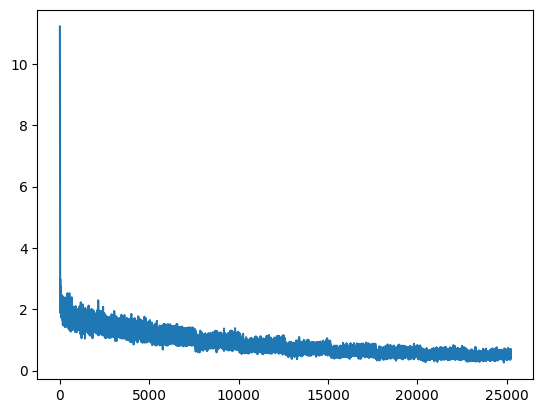

In [ ]:
plt.plot(losses)

In [ ]:
from tqdm import tqdm

In [ ]:
val_ids = [ i for i,_ in data2["English-Hindi"]["Test"].items()]

In [ ]:
from tqdm import tqdm
import torch

val_outs = []

for i in tqdm(range(len(test_ds))):
    enc_hid, enc_cell = encoder.ini_hid(batch_size=1, device=device)

    inp_ten = test_ds[i][0].unsqueeze(0).to(device)  # shape (1, seq_len)
    result = []

    with torch.no_grad():
        enc_out, enc_hid, enc_cell = encoder(
            inp_ten, enc_hid, enc_cell
        )

        def merge_bidir(hidden):
            hidden = hidden.view(encoder.num_lay, 2, 1, encoder.hs)
            return torch.tanh(hidden[:, 0, :, :] + hidden[:, 1, :, :])

        dec_hid = merge_bidir(enc_hid)
        dec_cell = merge_bidir(enc_cell)
        dec_inp = torch.tensor([SOS], device=device).unsqueeze(1)  # shape (1,1)

        for di in range(1, tar_len):
            decoder_output, dec_hid, dec_cell = decoder(
                dec_inp, dec_hid, dec_cell, enc_out
            )

            best = decoder_output.argmax(1)  # shape (1,)
            result.append(de_idx2_word[best.item()])

            if best.item() == EOS:
                break

            dec_inp = best.unsqueeze(1)

    result = [w for w in result if w not in ['<EOS>', '<PAD>', '<SOS>']]
    val_outs.append(" ".join(result))


100%|██████████| 23085/23085 [09:53<00:00, 38.87it/s]


In [ ]:
val_outs[0]

'और फिर हमें छात्रों छात्रों को करना चाहिए कि कंप्यूटर को सभी सभी पेपर पेपर में उपयोग कर सकते हैं और फिर भी एल्गोरिथ्म एल्गोरिथ्म है और कुछ भी कलन तरह से भी हम एक सरल फ़ीड के लिए एक फ़ीड के लिए कर सकते हैं।'

In [ ]:
df0 = pd.DataFrame()
df0["ID"] = val_ids
df0["Translation"] = val_outs

In [ ]:
df0.head()

,ID,Translation
0,540139,और फिर हमें छात्रों छात्रों को करना चाहिए कि क...
1,540140,जनवरी के पहले आयोजन के आयोजन कार्यक्रम के लिए ...
2,540141,इंदिरा गांधी राष्‍ट्रीय उद्यान के अंतर्गत जिले...
3,540142,स्थानीय साइट को भी आकर्षित करते हुए इस तरह की ...
4,540143,निश्चित रूप से इस पर कुछ और कुछ है।


In [ ]:
# df0.to_csv('answersH.csv', index = False)

In [ ]:
# x=pd.read_csv("/content/answersH.csv")

# Doing the above  thing for both language English-Bengali , English-Hindi .

In [ ]:
df1 = pd.read_csv("/content/answersB.csv") # Bengali
df2= pd.read_csv("/content/answersH.csv")  # Hindi

In [ ]:
df2.head()

In [ ]:
df3 = pd.concat([df1, df2]) #Concat

In [ ]:
df3

In [ ]:
df3.to_csv('answersBH.csv', index = False)

In [ ]:
filtered_data = pd.read_csv("/content/answersBH.csv")

In [ ]:
answer = "/content/answer.csv"
with open(answer, "w") as f:
  f.writelines("ID\tTranslation\n")
  for i in range(filtered_data.shape[0]):
    f.writelines(f'{filtered_data["ID"][i]}\t"{filtered_data["Translation"][i]}"\n')